## Let's attempt to use the TARGETIDs in order to match between the Williams cluster catalog and our calibration sample.

First, let's read in the calibration sample, the cluster catalog, and all of the observed targets in our sample.

In [1]:
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
from matplotlib import cm, colors
from matplotlib.patches import Ellipse
import matplotlib as mpl

from astropy.table import Table, vstack, join, unique
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as u
from astropy import constants as c

from scipy.spatial.distance import cdist, euclidean
import os
from corner import corner
import pickle
from tqdm import tqdm
from matplotlib.projections import get_projection_names
from desiutil.plots import init_sky
import requests
import math
import matplotlib.image as mpimg

In [5]:
sgagals = Table.read('SGA-2020_jura_Vrot_VI_ML_photocorr.fits')
catalog = Table.read('/global/cfs/cdirs/desi/users/ianw89/groupcatalogs/BGS_Y3/v0.3/GROUP_CATALOG_BGS_Y3_v0.3.fits')
tjura = Table.read('/global/homes/s/sgmoore1/DESI_SGA/TF/Y3/desi_pv_tf_jura_healpix.fits')

In [7]:
sgagals[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,R_ABSMAG_SB26_CORR,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,kpc,kpc,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes10
32,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.028016893,0.029046243,0.025209688,0.026244337,0.027134262,0.023817942,0.024750203,0.025650727,0.022882456,0.023803

In [9]:
catalog[:5]

TARGETID,RA,DEC,Z,L_GAL,VMAX,P_SAT,M_HALO,N_SAT,L_TOT,IGRP,WEIGHT,APP_MAG_R,Z_ASSIGNED_FLAG,G_R,IS_SAT,QUIESCENT,MSTAR
,deg,deg,,solLum,Mpc3,,solMass,,solLum,,,,,,,,solMass
int64,float64,float64,float64,float64,float64,float64,float64,int32,float64,int64,float64,float64,int32,float64,bool,bool,float64
39627351755068123,49.834953,-18.154497,0.223119,9910589000.0,500591000.0,0.0,926257900000.0,0,9910589000.0,0,0.304398,19.01287078857422,8,0.47272672668586324,False,False,--
39627351755069619,49.884101,-18.144277,0.077145,23113710000.0,3227000000.0,0.0,5430847000000.0,1,25390040000.0,1,0.417608,15.423483848571777,0,0.9535473819332729,False,True,81316050547.84206
39627351755069935,49.893713,-18.130689,0.23327,11987980000.0,577848500.0,0.0,2062001000000.0,0,11987980000.0,2,0.444981,19.000844955444336,0,0.8095572583204103,False,True,--
39627351759257696,49.928422,-18.144042,0.233045,10453490000.0,470522800.0,0.0,4801728000000.0,1,20394420000.0,3,0.450694,19.1475772857666,1,0.9369175687043381,False,True,--
39627351759257779,49.930442,-18.146842,0.233045,9940930000.0,522359000.0,0.972621,4801728000000.0,1,20394420000.0,3,0.304131,19.071929931640625,0,0.3366529553781312,True,False,--


In [10]:
overlap = join(catalog, tjura['TARGETID','SGA_ID'], keys='TARGETID', join_type='inner')
len(overlap)

110019

In [11]:
gals = join(overlap['TARGETID', 'RA', 'DEC', 'IGRP', 'SGA_ID'], sgagals, keys='SGA_ID', join_type='inner')
len(gals)

18930

In [12]:
gals[:5]

TARGETID,RA_1,DEC_1,IGRP,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,R_ABSMAG_SB26_CORR,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,kpc,kpc,,
int64,float64,float64,int64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes10
39633419310727441,212.024628,62.83853,6728502,32,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.0

In [13]:
tjura[:5]

TARGETID,TARGET_RA,TARGET_DEC,MEAN_FIBER_RA,MEAN_FIBER_DEC,STD_FIBER_RA,STD_FIBER_DEC,Z,ZERR,SPECTYPE,DELTACHI2,ZWARN,PVTYPE,SGA_ID,PHOTSYS,SKY_FIBER_DIST,SKY_FIBER_DIST_R26
int64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,int64,bytes3,int32,bytes1,float64,float64
-430502046,134.00013295228783,5.934552839997555,134.0000012447711,5.934402495943119,0.0,0.0,1.5211813094599733,9.536633276548175e-05,GALAXY,21.043927863240242,2049,TFT,838970,S,0.0,0.0
-427872363,61.981718642816155,-22.823913110732356,61.981815755036905,-22.824112647850505,0.01692960597574711,0.01899055577814579,0.049085960824979194,8.765385426009584e-06,GALAXY,320.327581204474,2049,TFT,982213,S,0.0,0.0
-411444222,156.2181500220905,7.1584828480845655,156.21807676457115,7.1586258676041306,0.0,0.0,0.7655265334224575,0.00014819907104570706,GALAXY,2.862433671951294,2053,TFT,4614,S,0.0,0.0
-261707523,51.18809619857989,-15.380001206793725,51.18805131712048,-15.379972719695512,0.18443052470684052,0.270201712846756,0.11706841864860068,1.263477560383397e-05,GALAXY,5022.345633155666,512,SGA,788458,S,0.0,0.0
-260779407,138.32747528464944,17.5639019859795,138.32760054746495,17.56391743552376,0.0,0.0,0.08569271543378945,9.438671035622181e-06,GALAXY,243.51359286904335,2560,TFT,735997,S,0.0,0.0


## If we have duplicates for a given SGA_ID, make sure the group assignment is the same

In [14]:
from collections import defaultdict
import numpy as np

# Group rows by sga_id
sga_to_igrp = defaultdict(list)

for row in gals:
    sga_to_igrp[row['SGA_ID']].append(row['IGRP'])

# Now check for discrepancies
conflicting_sga_ids = []

for sga_id, igrps in sga_to_igrp.items():
    if len(igrps) > 1:
        unique_igrps = set(igrps)
        if len(unique_igrps) > 1:
            conflicting_sga_ids.append((sga_id, list(unique_igrps)))

# Output result
print(f"Found {len(conflicting_sga_ids)} sga_id(s) with conflicting igrp values:")
for sga_id, igrps in conflicting_sga_ids:
    print(f"  sga_id {sga_id}: igrp values = {igrps}")


Found 1 sga_id(s) with conflicting igrp values:
  sga_id 585627: igrp values = [2575709, 2575710]


In these cases, we will want to keep the target that is closest to the center, and the group that would result from that. Since there is only 2, we will compute them directly.

In [15]:
probs = gals[gals['SGA_ID'] == 585627]

cluster_coords = SkyCoord(ra=probs['RA_1'], 
                          dec=probs['DEC_1'], 
                          unit=u.degree)
gal_coords = SkyCoord(ra=probs['RA_2'], 
                            dec=probs['DEC_2'], 
                            unit=u.degree)
    
sep2d = gal_coords.separation(cluster_coords)
bad_idx = np.argmax(sep2d)

## Now, let's remove the off target from our list
gals = gals[gals['TARGETID'] != probs['TARGETID'][bad_idx]]


# probs2 = gals[gals['SGA_ID'] == 1397208]

# cluster_coords2 = SkyCoord(ra=probs2['RA_1'], 
#                           dec=probs2['DEC_1'], 
#                           unit=u.degree)
# gal_coords2 = SkyCoord(ra=probs2['RA_2'], 
#                             dec=probs2['DEC_2'], 
#                             unit=u.degree)
    
# sep2d2 = gal_coords2.separation(cluster_coords2)
# bad_idx2 = np.argmax(sep2d2)

# gals = gals[gals['TARGETID'] != probs2['TARGETID'][bad_idx2]]



In [16]:
print(len(gals))

18929


In [17]:
#Recheck to make sure there are no issues anymore


# Group rows by sga_id
sga_to_igrp = defaultdict(list)

for row in gals:
    sga_to_igrp[row['SGA_ID']].append(row['IGRP'])

# Now check for discrepancies
conflicting_sga_ids = []

for sga_id, igrps in sga_to_igrp.items():
    if len(igrps) > 1:
        unique_igrps = set(igrps)
        if len(unique_igrps) > 1:
            conflicting_sga_ids.append((sga_id, list(unique_igrps)))

# Output result
print(f"Found {len(conflicting_sga_ids)} sga_id(s) with conflicting igrp values:")
for sga_id, igrps in conflicting_sga_ids:
    print(f"  sga_id {sga_id}: igrp values = {igrps}")

Found 0 sga_id(s) with conflicting igrp values:


In [18]:
gals

TARGETID,RA_1,DEC_1,IGRP,SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA_2,DEC_2,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,R_ABSMAG_SB26_CORR,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI
,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,kpc,kpc,,
int64,float64,float64,int64,int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes10
39633419310727441,212.024628,62.83853,6728502,32,SGA-2020 32,PGC2644444,2644444,212.02461,62.8385803,Sc,26.25,0.3758374,0.60255957,0.09556411,23.73748,17.234,False,LEDA-20181114,10,PGC2644444,1,True,212.02461,62.8385803,0.3758374,2122p627,212.02462598739942,62.838526399057336,0.68802845,SB26,22.800411,0.4168182,212.02444469714254,62.83861910315144,15.352884,7.5523267,7.0574827,6.552769,6.8422165,9.006861,11.119019,13.218836,14.83576,16.089632,17.419872,18.262827,20.640854,17.682621,16.800076,16.140163,17.36588,16.500635,15.859558,17.164816,16.315928,15.683345,17.029795,16.192858,15.569851,16.956533,16.127148,15.511885,16.912262,16.09487,15.481129,16.881954,16.068357,15.467079,16.868856,16.055609,15.458797,16.854921,16.045063,15.448293,0.076427355,0.10654599,0.14980716,0.14600274,0.17229652,0.11901944,0.1291893,0.1625502,0.3402725,0.028715666,0.03028943,0.031358354,0.026863642,0.0

## Keep this 1-to-1 paring between groups and SGA IDs

In [19]:
## we only care about the sga_ids and their corresponding groups
clusters = gals['SGA_ID', 'IGRP', 'RA_1','DEC_1']

# now remove the duplicate entries that we would hvae 
clusters=unique(clusters)

In [20]:
### See how many matches we got
len(clusters)

18308

In [21]:
clusters.write('Jura_Williams_Y3_TargetID_Matches.fits')

# Now let's see if we get more matches by just looking at the separation distances

For each galaxy in our calibration set, find the closest match in the Williams catalog.

In [22]:
## Sky coordinates of SGA galaxies that passed quality selection
sga_coords = SkyCoord(sgagals['RA'], sgagals['DEC'], unit='deg')

## sky coordinates of the Williams catalog galaxies
williams_coords = SkyCoord(catalog['RA'], catalog['DEC'], unit='deg')

match_ids, match_dist, _ = sga_coords.match_to_catalog_sky(williams_coords)

## Let's use these matches to add the group as a new column in our table
sgagals['RA_CAT'] = catalog['RA'][match_ids]
sgagals['DEC_CAT']= catalog['DEC'][match_ids]
sgagals['Williams_Group'] = catalog['IGRP'][match_ids]

#### now let's get the relative separation which is the separation divided by R26
sgagals['rel_sep'] = (2 * match_dist.to('arcmin')) / (sgagals['D26']*u.arcmin)

In [23]:
len(sgagals[sgagals['rel_sep'] < 0.1])

18322

In [24]:
close_matches = sgagals[sgagals['rel_sep'] < 0.1]
len(close_matches)

18322

In [25]:
len(np.unique(close_matches['SGA_ID']))

18322

In [26]:
#### see if these include all the same objects from the TARGETID matching:

dups = join(clusters, close_matches, keys='SGA_ID', join_type='inner')
print(len(dups))
print('Total objects from targetid match:', len(clusters))

18308
Total objects from targetid match: 18308


In [22]:
#### Figure out which one is diffreent
mask = ~np.isin(close_matches['SGA_ID'], clusters['SGA_ID'])
# Select only the non-overlapping entries
diffs = close_matches[mask]
diffs

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_err,PHOTSYS,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,R26_kpc,R26_kpc_err,R_ABSMAG_SB26_CORR,D26_kpc,DIST_MAX,MAX_VOL_FRAC,MORPHTYPE_AI,RA_CAT,DEC_CAT,Williams_Group,rel_sep
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,kpc,kpc,,kpc,kpc,,,deg,deg,,
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,bytes32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes10,float64,float64,int64,float64
509259,SGA-2020 509259,PGC1048018,1048018,147.44650049999998,-5.1933055999999995,--,62.0,0.37153524,0.45708817,-99.0,23.738482,17.26,False,LEDA-20181114,185066,PGC1048018,1,True,147.44650049999998,-5.1933055999999995,0.37153524,1475m052,147.446207505031,-5.193443599395776,0.6144021,SB26,63.173183,0.41328698,147.44612965438262,-5.193372862915122,11.982184,5.3897166,5.2670684,4.9765587,6.4865775,8.181746,9.783757,11.064174,12.267235,13.504705,14.653376,16.478386,18.432064,17.583527,16.766272,16.144989,17.365807,16.55185,15.942743,17.231735,16.419622,15.817591,17.15525,16.343515,15.744243,17.101046,16.290659,15.698722,17.070518,16.267683,15.675069,17.052181,16.249851,15.661155,17.03615,16.235523,15.647932,17.022448,16.221996,15.637786,0.08033711,0.1039957,0.10363625,0.13972332,0.08984636,0.112578586,0.14589751,0.25227243,0.17247064,0.033186648,0.034198098,0.03725538,0.030

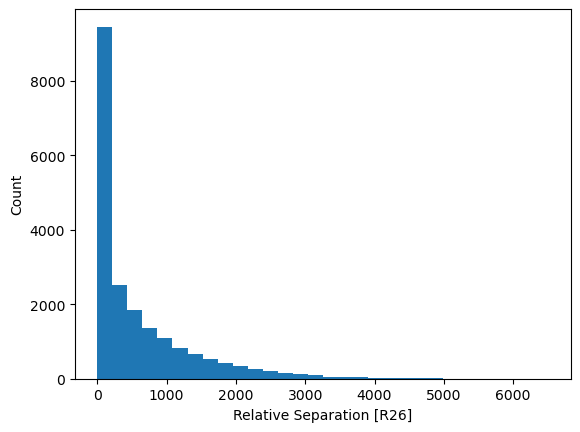

In [23]:
## plot a histogram of the separations to make sure this did what we wanted, and that everything is close
plt.figure()
plt.hist(sgagals['rel_sep'], bins=30)
plt.xlabel('Relative Separation [R26]')
plt.ylabel('Count')
# plt.yscale('log')
plt.show()

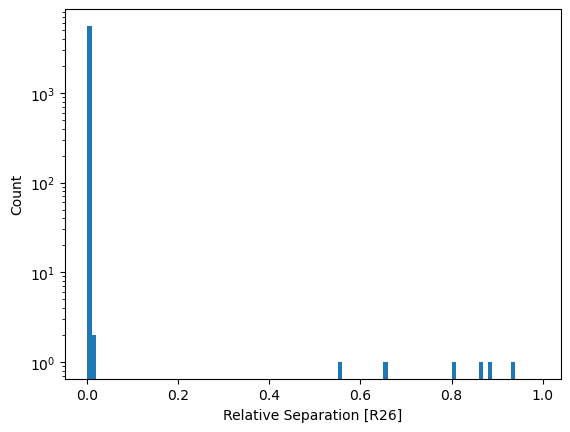

In [24]:
## plot a histogram of the separations to make sure this did what we wanted, and that everything is close
plt.figure()
plt.hist(sgagals['rel_sep'], bins=np.arange(0,1,0.01))
plt.xlabel('Relative Separation [R26]')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

## We get the exact same objects (plus 1 or 2).

# VI where the matches fall on the sky

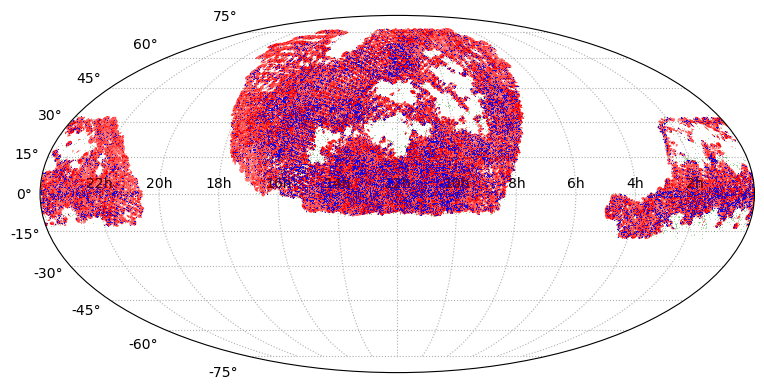

In [27]:
#Get the location of all Williams catalog galaxies
catalog_coords = SkyCoord(ra=catalog['RA'], 
                          dec=catalog['DEC'], 
                          unit=u.degree)
gal_coords = SkyCoord(ra=sgagals['RA'], 
                            dec=sgagals['DEC'], 
                            unit=u.degree)
match_coords = SkyCoord(ra=clusters['RA_1'], 
                            dec=clusters['DEC_1'], 
                            unit=u.degree)

fig, ax = plt.subplots(figsize=(10,4), tight_layout=True, subplot_kw={'projection' : 'mollweide'})

ra_catalog = np.radians(180*u.deg - catalog_coords.ra)
dec_catalog = np.radians(catalog_coords.dec)
ax.plot(ra_catalog, dec_catalog, '.', color='red', alpha=0.3, ms=0.1, mew=0.1)

ra_gal = np.radians(180*u.deg - gal_coords.ra)
dec_gal = np.radians(gal_coords.dec)
ax.plot(ra_gal, dec_gal, '.', color='green', ms=0.3, mew=0.3)

ra_match = np.radians(180*u.deg - match_coords.ra)
dec_match = np.radians(match_coords.dec)
ax.plot(ra_match, dec_match, '.', color='blue', ms=0.5, mew=0.5)

ax.set(xticklabels=[f'{_}h' for _ in np.arange(2,24, 2)][::-1])
ax.grid(ls=':');


So, the mismatch between the footprints likely explains why we are only recovering ~25% of the galaxies in our sample.

Now, let's VI the objects with separations below 2 to see if these are reasonable matches.

In [31]:
#### Function to actually pull image cutouts from legacysurvey to view the galaxies
def get_cutout(sgaid, ra, dec, size, verbose=False):
    """Grab and cache legacy survey cutouts.
    
    Parameters
    ----------
    sgaid : int
        SGA galaxy ID.
    ra : float
        Right ascension (degrees).
    dec : float
        Declination (degrees).
    verbose : bool
        Add some status messages if true.
        
    Returns
    -------
    img_name : str
        Name of JPG cutout file written after query.
    w : astropy.wcs.WCS
        World coordinate system for the image.
    """
    # Either load an existing image or download a cutout.
    img_name = 'cache/sga_{}.jpg'.format(sgaid)
    
    if os.path.exists(img_name):
        if verbose:
            print('{} exists.'.format(img_name))
    else:
        img_url = 'https://www.legacysurvey.org/viewer/cutout.jpg?ra={}&dec={}&zoom=14&layer=ls-dr9&size={}&sga'.format(ra, dec, size)
        if verbose:
            print('Get {}'.format(img_url))
            
        with open(img_name, 'wb') as handle: 
            response = requests.get(img_url, stream=True) 
            if not response.ok: 
                print(response) 
            for block in response.iter_content(1024): 
                if not block: 
                    break 
                handle.write(block)
                
    # Set up the WCS.
    wcs_input_dict = {
        'CTYPE1': 'RA---TAN',
        'CUNIT1': 'deg',
        'CDELT1': -0.262/3600,
        'CRPIX1': size/2 + 0.5,
        'CRVAL1': ra,
        'NAXIS1': size,
        'CTYPE2': 'DEC--TAN',
        'CUNIT2': 'deg',
        'CDELT2': 0.262/3600,
        'CRPIX2': size/2 + 0.5,
        'CRVAL2': dec,
        'NAXIS2': size
    }
    w = WCS(wcs_input_dict)
    
    return img_name, w

In [32]:
### function to generate the image with the sga and catalog center circles on them
def get_images(obj):
    # Retrieve SGA ID of galaxy
    sga_id = obj['SGA_ID']
    # print(sga_id)
    
    # Coordinates of SGA galaxy's center   
    center = (obj['RA_CAT'],obj['DEC_CAT'])
    # string_center = center.to_string(decimal = True) 
    # center_coords = string_center.split()
    ra, dec = float(obj['RA']), float(obj['DEC'])
    # print(ra, dec)
    
    # D26 in arcmin
    d26  = obj['D26']
    # print(d26)
    
    #---------------------------------------------------------------------------
    # Padd the image cutout of the galaxy.
    # Multiply by 60 (to arcsec), divide by 180 to get pixscale.
    npix = np.minimum(int(1.025 * d26*60/0.262), 512)
    
    #print(targetid, sga_id, ra, dec)
    img_file, wcs = get_cutout(sga_id, ra, dec, size=npix, verbose=False)
    img = mpl.image.imread(img_file)

    fig1 = plt.figure(figsize=(7,5))
    
    ax = fig1.add_subplot(1, 1, 1, projection=wcs)
    ax.imshow(np.flip(img, axis=0))
    ax.plot(ra, dec, color = "red", markersize = 30)
    ax.set(xlabel='ra', ylabel='dec')
    overlay = ax.get_coords_overlay('icrs')
    overlay.grid(color='white', ls='dotted')

    r1 = SphericalCircle((center[0] * u.deg, center[1] * u.deg), 0.05*d26*60*u.arcsec, edgecolor='orange', linewidth=1, facecolor='none', transform=ax.get_transform('icrs'))
    r2 = SphericalCircle((ra * u.deg, dec * u.deg), 0.05*d26*60*u.arcsec, edgecolor='red', linewidth=1, facecolor='none', transform=ax.get_transform('icrs'))
    ax.add_patch(r1)
    ax.add_patch(r2)
    
    fig1.subplots_adjust(top=0.85, right=0.85, bottom=0.15, left=0.15)
    
    fig1.savefig('cache/jura_VI_cutouts/sga_{}.png'.format(sga_id), dpi=120)
    
    fig1.clear()
    plt.close(fig1)

In [33]:
#### function to display the desired cutouts
def show_cutouts(sga_ids, img_dir='cache/jura_VI_cutouts', n_cols=5):

    image_files = [f'sga_{sga_id}.png' for sga_id in sga_ids]
    existing_files = [f for f in image_files if os.path.exists(os.path.join(img_dir, f))]

    if not existing_files:
        print("No matching image files found.")
        return

    n_images = len(existing_files)
    n_rows = math.ceil(n_images / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
    axes = axes.flatten()

    for i, img_file in enumerate(existing_files):
        img_path = os.path.join(img_dir, img_file)
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(img_file.replace('.png', ''), fontsize=10)
        axes[i].axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


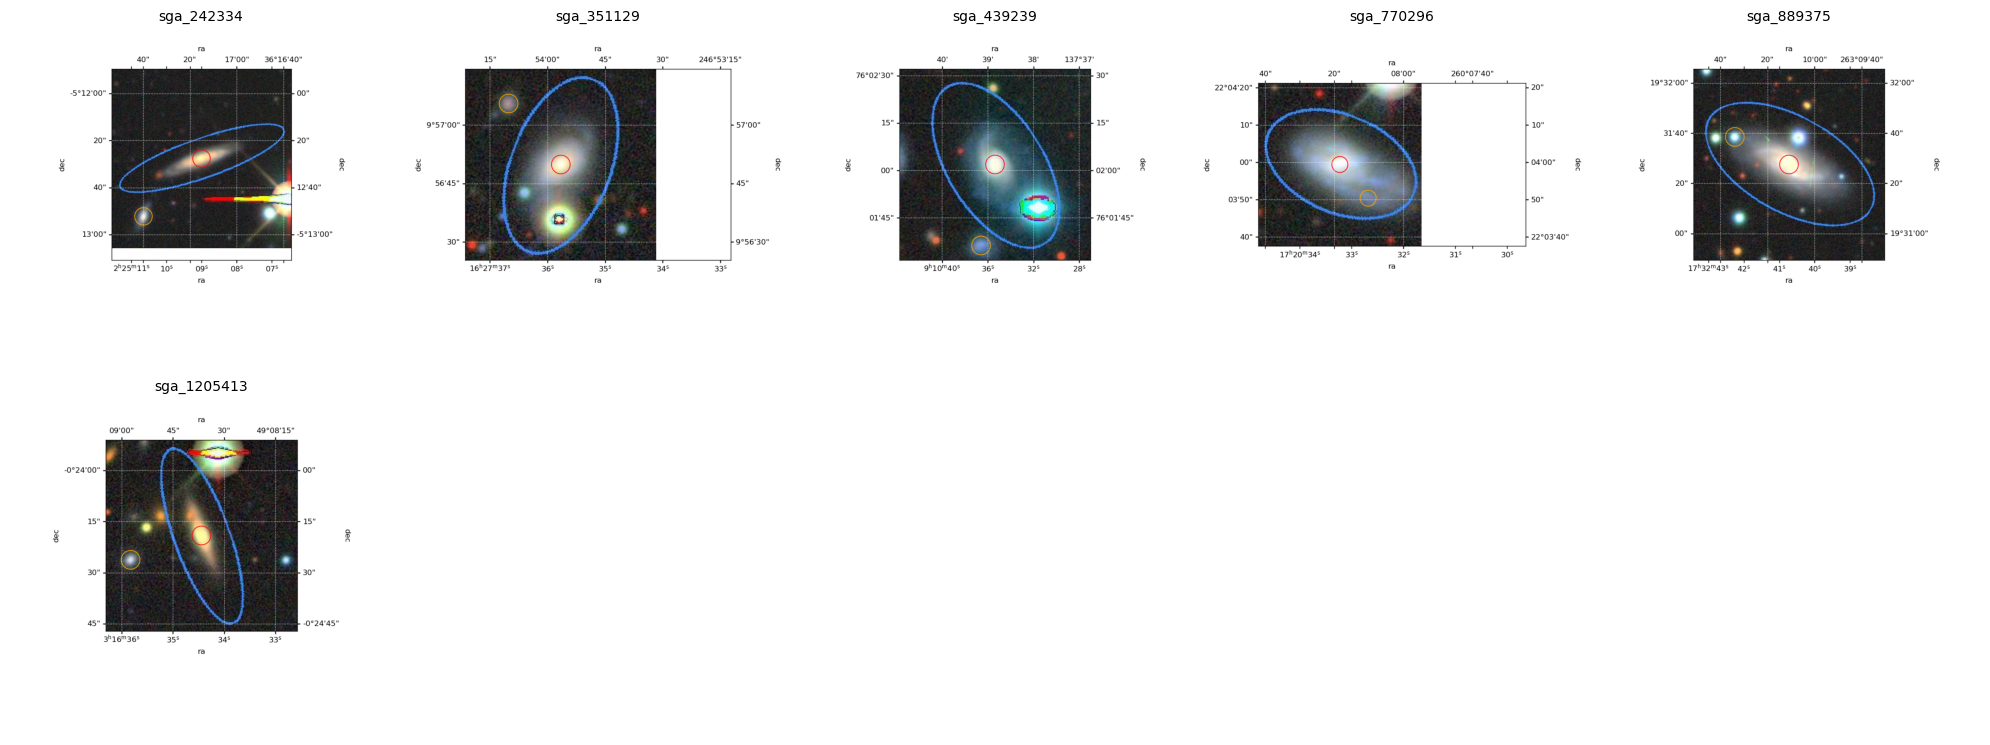

In [39]:
### Generate these figures, and show the objects within the desired separation interval 
test_match = sgagals[(sgagals['rel_sep'] > 0.1) & (sgagals['rel_sep'] < 1)]

for i in range(0,len(test_match)): 
    get_images(test_match[i])

show_cutouts(test_match['SGA_ID'])

Only one of these is actually a good match, and it's the closest one, so we will actually just make the cut at $0.6*R_{26}$ to include this one, and assume that everything larger is not a true match.

In [40]:
close_matches = sgagals[sgagals['rel_sep'] < 0.6]
close_matches.write('Jura_Williams_Coordinate_Matches.fits', overwrite=True)